# African Nations and Ruggedness

Example from Statistical Rethinking chapter 7. Code adapted from "Statistical Rethinking with Python and PyMC3" at https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3; code by contributors to that repository and Dylan Murphy.

In this example, we examine the effect of terrain ruggedness on economy on different continents.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Load the data

In [2]:
d = pd.read_csv('data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
africa = dd[dd.cont_africa==1]  # Africa
others = dd[dd.cont_africa==0]  # not Africa
dd.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0,0,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0,0,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0,0,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343


#### A pooled regression

In [3]:
# Model the entire data
with pm.Model() as model_all:
    a = pm.Normal('a', mu=9, sd=3)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd['rgdppc_2000']))
    trace_all = pm.sample(1000, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


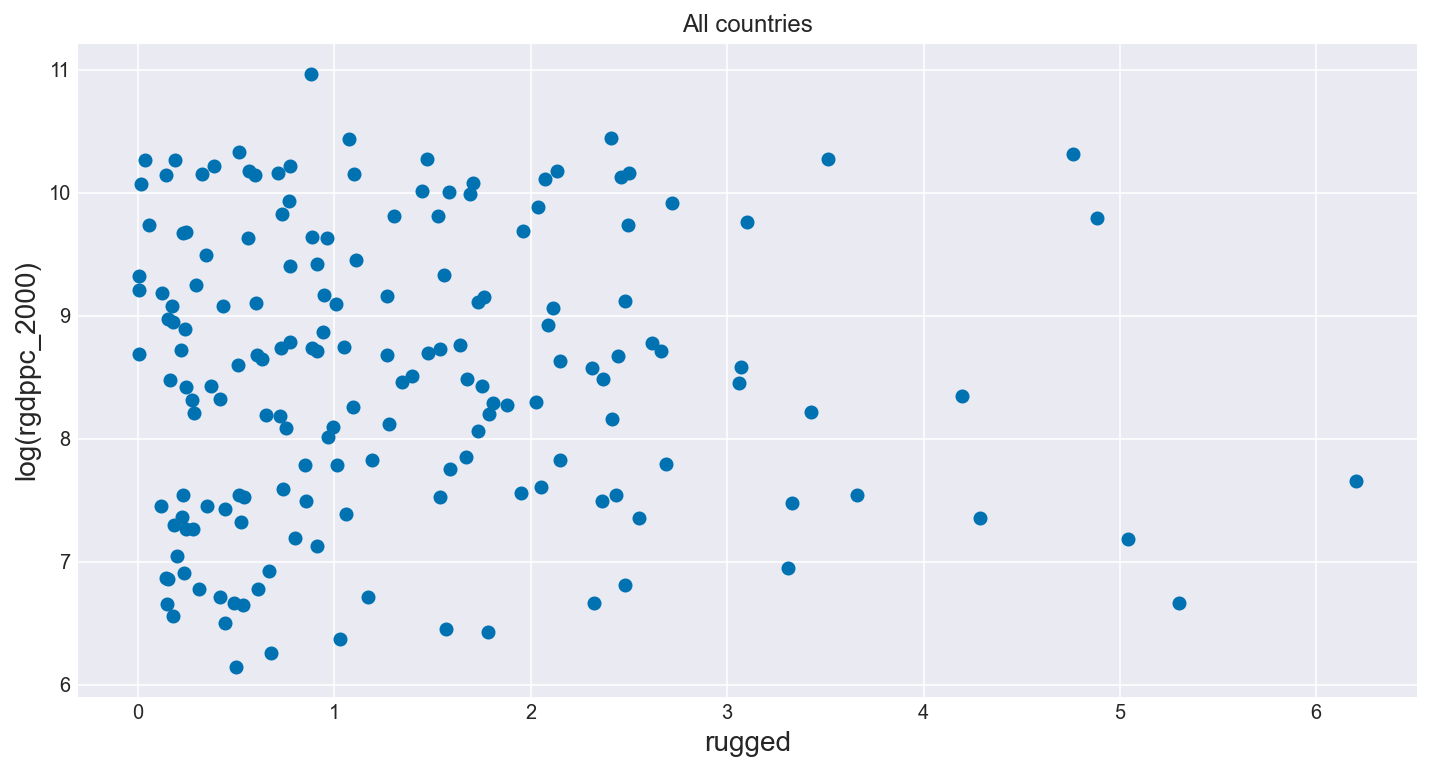

In [4]:
mu_mean = trace_all['mu']
mu_hpd = az.hdi(mu_mean)

fig = plt.figure(figsize=(12,6))
plt.plot(dd['rugged'], np.log(dd['rgdppc_2000']), 'C0o')
#plt.plot(dd['rugged'], mu_mean.mean(0), 'C2')
#plt.plot(dd.iloc[149]['rugged'], np.log(dd.iloc[149]['rgdppc_2000']), 'ro')
idx = np.argsort(dd['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
#plt.fill_between(dd['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5)
plt.title('All countries')
plt.ylabel('log(rgdppc_2000)', fontsize=14);
plt.xlabel('rugged', fontsize=14)
plt.savefig('allcountries.png')

#### Fitting two separate regression models

Here, we fit separate regression models for African and non-African nations. 

In [5]:
# Fit the regression models with this code.
# African nations
with pm.Model() as african_model:
    a = pm.Normal('a', mu=9, sd=3)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    mu = pm.Deterministic('mu', a + bR * africa['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(africa['rgdppc_2000']))
    trace_africa = pm.sample(1000, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


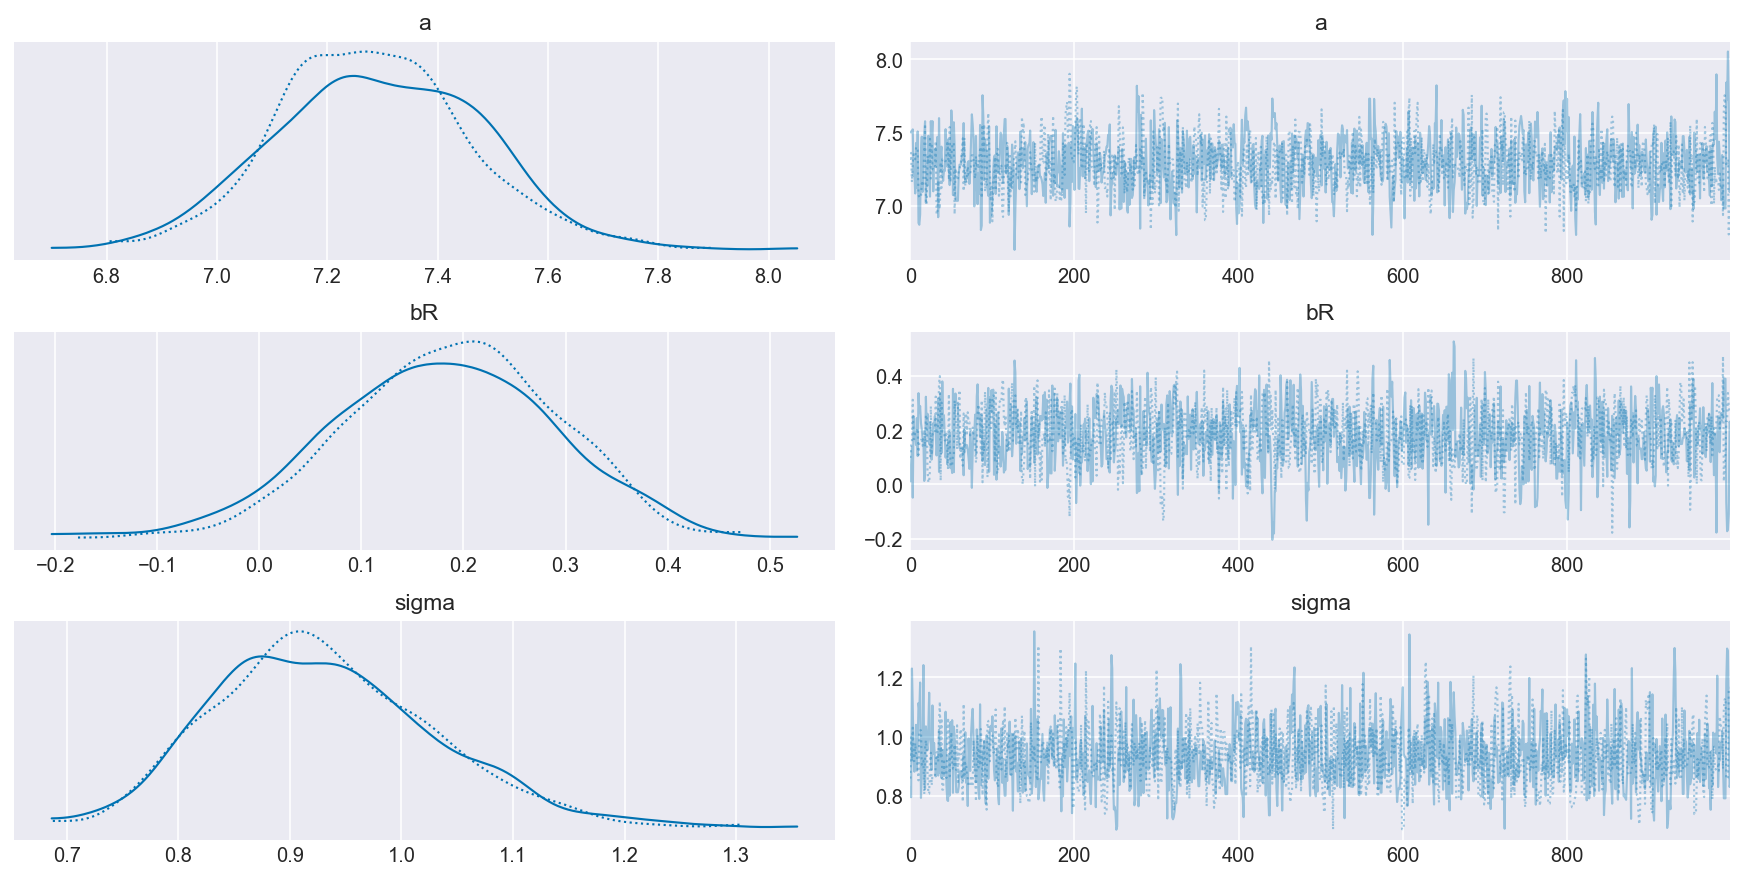

In [6]:
varnames = ['a', 'bR', 'sigma']
az.plot_trace(trace_africa, varnames);

In [7]:
# non-African nations
with pm.Model() as model_other:
    a = pm.Normal('a', mu=9, sd=3)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    mu = pm.Deterministic('mu', a + bR * others['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(others['rgdppc_2000']))
    trace_others = pm.sample(1000, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


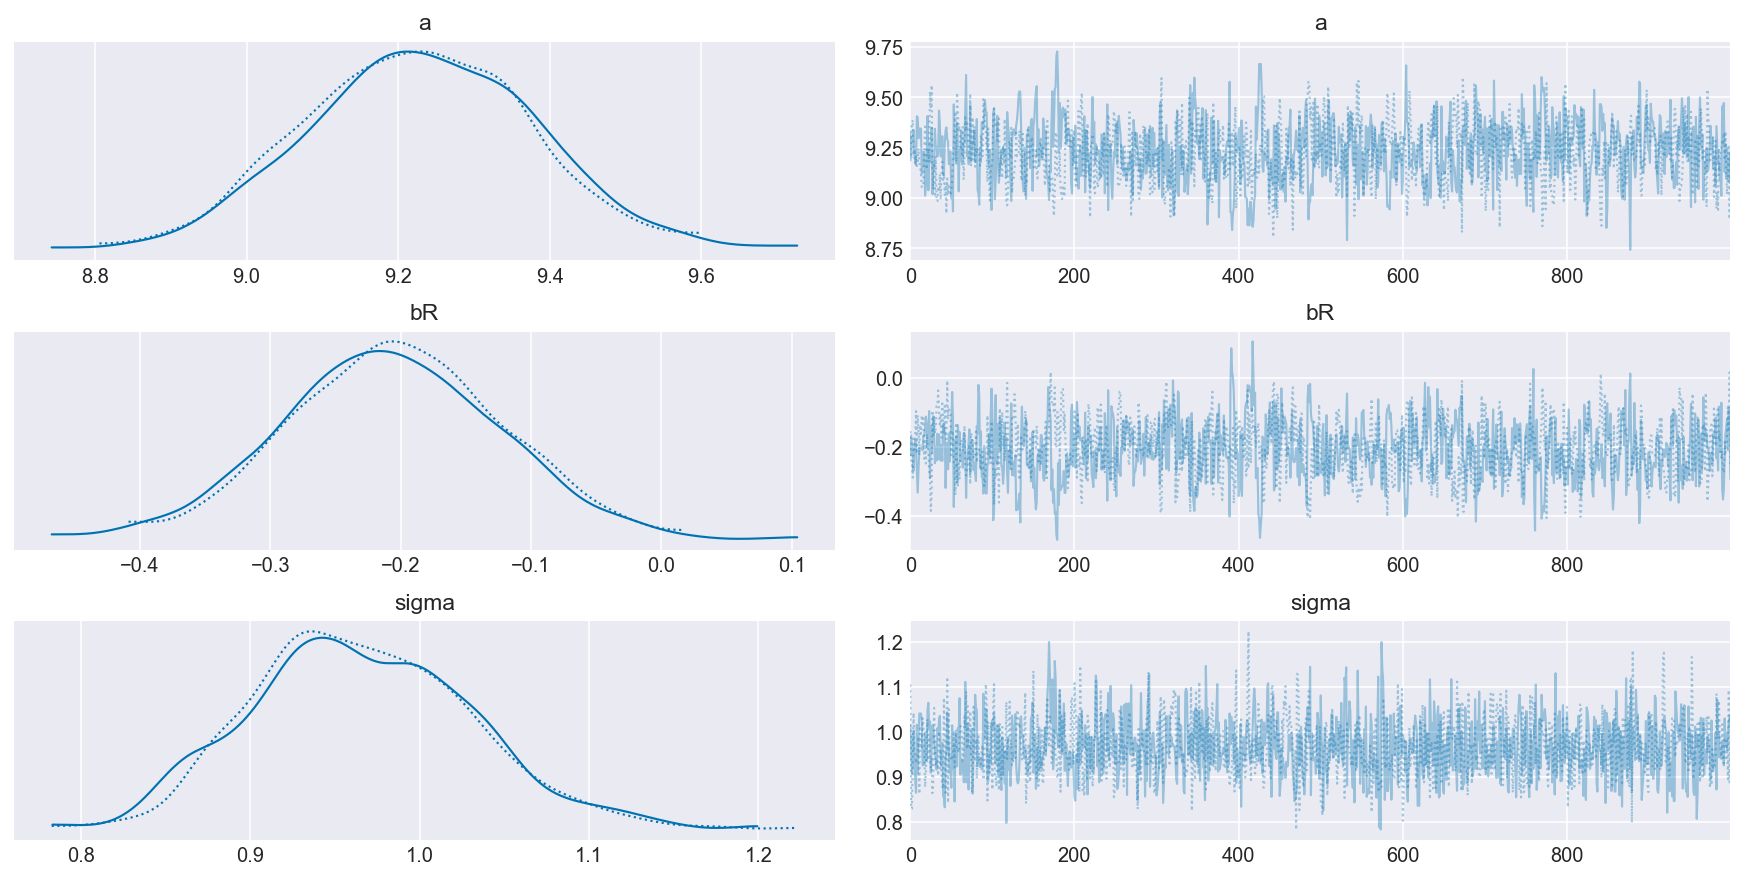

In [8]:
az.plot_trace(trace_others, varnames);

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


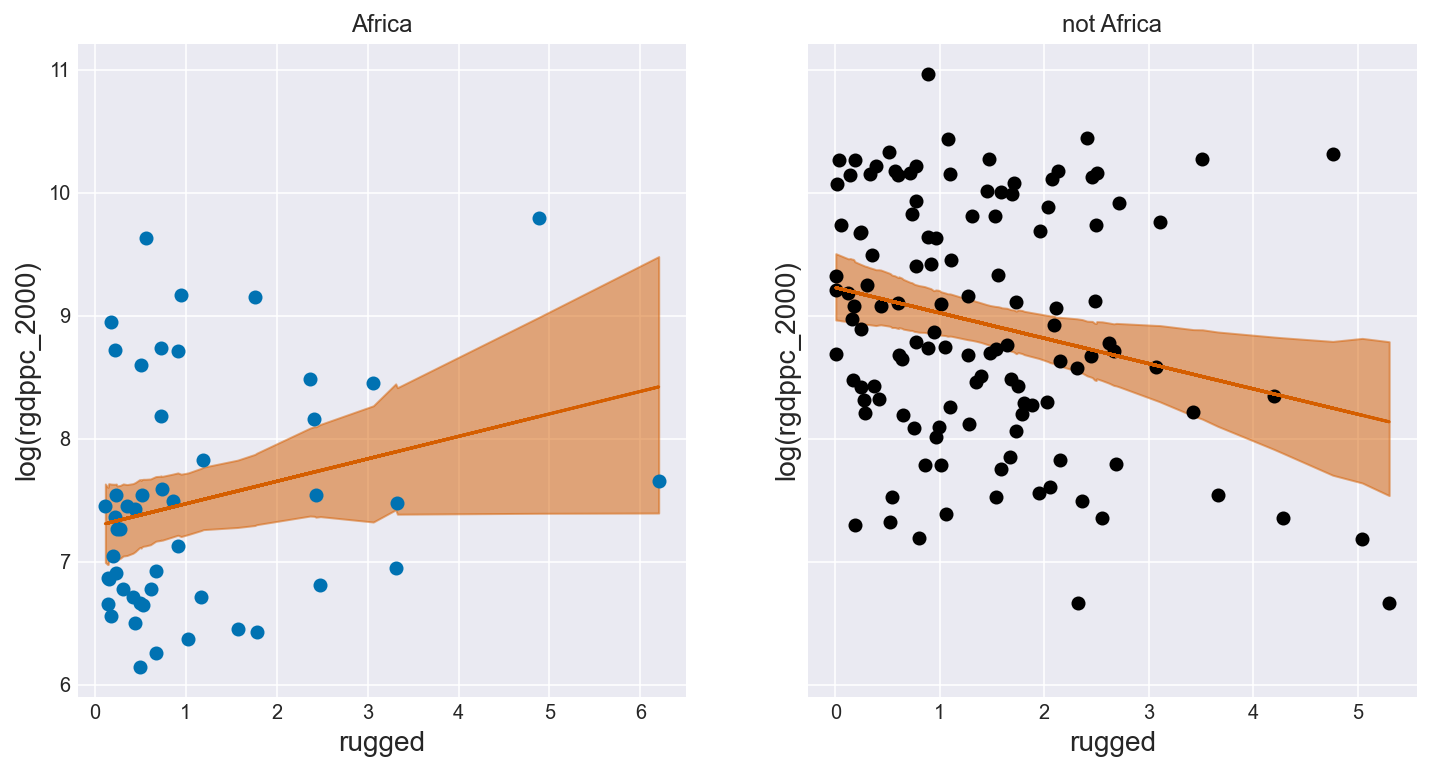

In [9]:
# Plot the data

mu_mean = trace_africa['mu']
mu_hpd = az.hdi(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
ax1.plot(africa['rugged'], np.log(africa['rgdppc_2000']), 'C0o')
ax1.plot(africa['rugged'], mu_mean.mean(0), 'C2')
idx = np.argsort(africa['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(africa['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_others['mu']
mu_hpd = az.hdi(mu_mean)

ax2.plot(others['rugged'], np.log(others['rgdppc_2000']), 'ko')
ax2.plot(others['rugged'], mu_mean.mean(0), 'C2')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14)
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(others['rugged'])
ax2.fill_between(others['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5);


#### A pooled regression, but with a dummy variable for Africa

Here, we attempt to do a little better by including a dummy variable for Africa. As we'll see, this isn't really enough -- because it doesn't allow the slopes to vary.

In [10]:
# Model the entire data including a dummy variable
with pm.Model() as model_all_dummy:
    a = pm.Normal('a', mu=9, sd=3)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd['rugged'] + bA * dd['cont_africa'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_all_dummy = pm.sample(1000, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Plotting the regressions

In [11]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_all_dummy['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_all_dummy['bR'])))

for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_all_dummy['a'] + trace_all_dummy['bR'] * rugged_seq[iSeq] + trace_all_dummy['bA'] * 0
    mu_pred_Africa[iSeq] = trace_all_dummy['a'] + trace_all_dummy['bR'] * rugged_seq[iSeq] + trace_all_dummy['bA'] * 1 

In [12]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = az.hdi(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = az.hdi(mu_pred_Africa.T)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


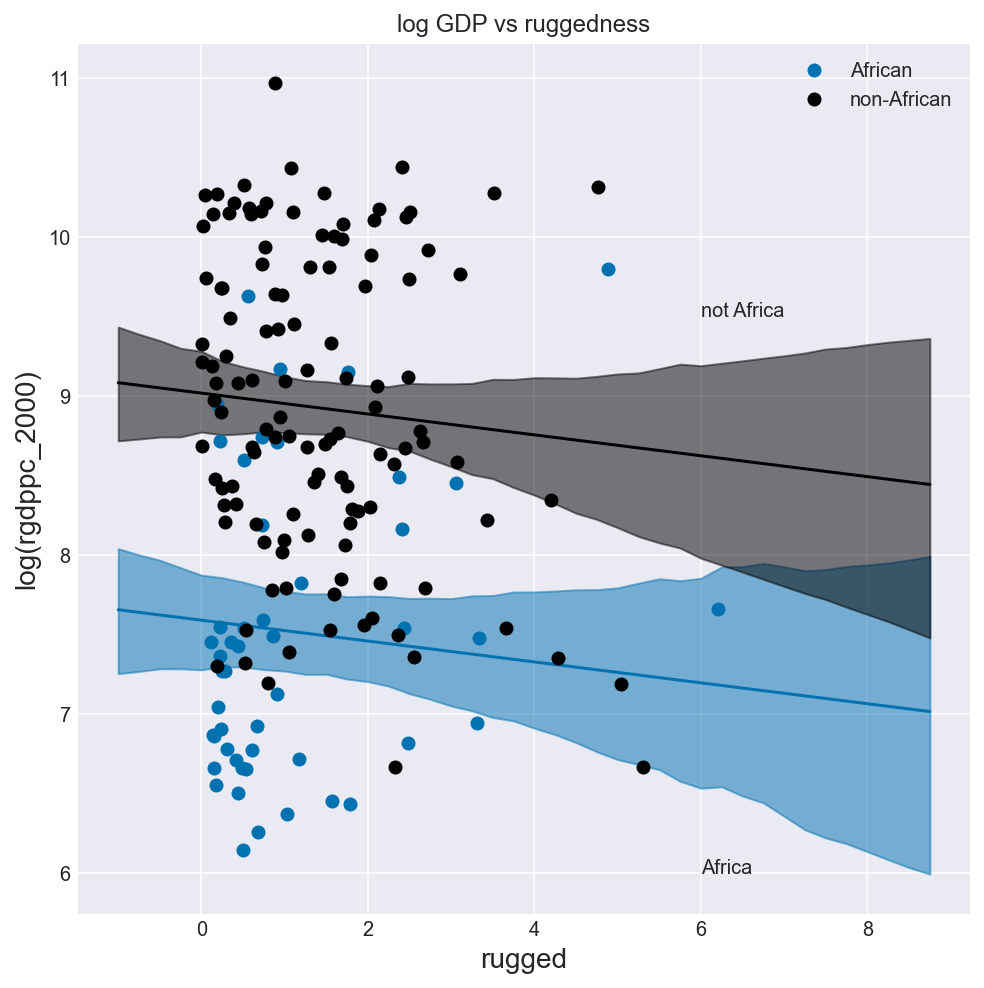

In [13]:
plt.figure(figsize=(8,8))
plt.plot(africa['rugged'], np.log(africa['rgdppc_2000']), 'C0o', label = 'African')
plt.plot(rugged_seq, mu_mean_Africa, 'C0')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
plt.plot(others['rugged'], np.log(others['rgdppc_2000']), 'ko', label = 'non-African')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
plt.annotate('not Africa', xy=(6, 9.5))
plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14)
plt.xlabel('rugged', fontsize=14)
plt.title('log GDP vs ruggedness')
plt.legend()
plt.show()

#### Two approaches to modeling interactions

We can model the interactions directly, by including a product term in the model equation, or by indexing two separate slopes and fitting them using a multilevel model.

In [14]:
with pm.Model() as model_product:
    a = pm.Normal('a', mu=9, sd=3)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 5)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_product = pm.sample(1000, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


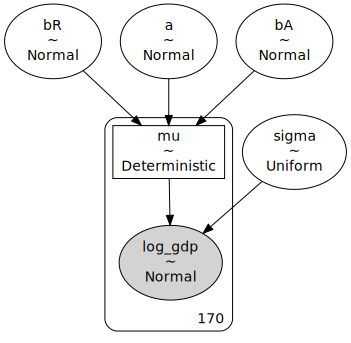

In [15]:
pm.model_to_graphviz(model_all_dummy)

In [16]:
az.summary(trace_product, var_names = ['a', 'bR', 'bA', 'bAR'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.185,0.145,8.913,9.462,0.005,0.004,738.0,1049.0,1.01
bR,-0.184,0.081,-0.338,-0.031,0.003,0.002,777.0,901.0,1.00
bA,-1.839,0.233,-2.295,-1.437,0.008,0.006,791.0,1074.0,1.01
bAR,0.342,0.138,0.088,0.607,0.005,0.004,773.0,976.0,1.01


In [17]:
graph = pm.model_to_graphviz(model_product)
graph.render('africa_product')

'africa_product.pdf'

In [18]:
with pm.Model() as model_ml:
    a = pm.Normal('a', mu=9, sd=3, shape = 2)
    tau = pm.HalfCauchy('tau', 5)
    b = pm.Normal('b', mu = 0, sd = tau, shape = 2)
    sigma = pm.HalfCauchy('sigma', 5)
    mu = pm.Deterministic('mu', a[dd['cont_africa']] + b[dd['cont_africa']] * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd['rgdppc_2000']))
    trace_ml = pm.sample(1000, target_accept = 0.95, tune=1000)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, tau, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [19]:
graph = pm.model_to_graphviz(model_ml)
graph.render('africa_ml')

'africa_ml.pdf'

In [20]:
az.summary(trace_ml, var_names = ['a', 'b'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],9.197,0.142,8.933,9.454,0.004,0.003,1080.0,1183.0,1.0
a[1],7.313,0.183,6.955,7.640,0.005,0.004,1236.0,962.0,1.0
b[0],-0.183,0.081,-0.324,-0.027,0.003,0.002,948.0,927.0,1.0
b[1],0.157,0.105,-0.045,0.352,0.003,0.002,1107.0,1118.0,1.0


In [21]:
az.summary(trace_product, var_names = ['a', 'bR', 'bA', 'bAR'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.185,0.145,8.913,9.462,0.005,0.004,738.0,1049.0,1.01
bR,-0.184,0.081,-0.338,-0.031,0.003,0.002,777.0,901.0,1.00
bA,-1.839,0.233,-2.295,-1.437,0.008,0.006,791.0,1074.0,1.01
bAR,0.342,0.138,0.088,0.607,0.005,0.004,773.0,976.0,1.01


#### Model comparison

In [22]:
comp_df = az.compare({'pooled':trace_all, 'noninteracting':trace_all_dummy, 'product':trace_product, 'multilevel':trace_ml}, ic='loo', scale='log')
comp_df

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
multilevel,0,-234.796325,5.190453,0.000000,0.949721,7.351718,0.000000,False,log
product,1,-234.850849,5.179328,0.054525,0.000000,7.281179,0.291352,False,log
noninteracting,2,-238.176054,4.332340,3.379730,0.050279,7.411825,2.885431,False,log
pooled,3,-269.806903,2.638970,35.010579,0.000000,6.461357,7.546570,False,log


In [23]:
az.loo(trace_all, pointwise = True).pareto_k.argmax()

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.DataArray 'pareto_shape' ()>
array(149)

In [24]:
dd.iloc[149]

isocode                          TJK
isonum                           762
country                   Tajikistan
rugged                         5.301
rugged_popw                    1.033
rugged_slope                  15.976
rugged_lsd                      1.54
rugged_pc                     75.473
land_area                    13996.0
lat                           38.527
lon                           71.038
soil                          17.449
desert                         0.025
tropical                         0.0
dist_coast                     1.505
near_coast                       0.0
gemstones                          0
rgdppc_2000                  785.469
rgdppc_1950_m                    NaN
rgdppc_1975_m                    NaN
rgdppc_2000_m                883.162
rgdppc_1950_2000_m               NaN
q_rule_law                     -1.61
cont_africa                        0
cont_asia                          1
cont_europe                        0
cont_oceania                       0
c

In [25]:
az.compareplot(comp_df);

AttributeError: module 'arviz' has no attribute 'compareplot'

#### The interaction model, rewritten

In [ ]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000, tune=1000)

#### Visualizing the regressions
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.

In [ ]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [ ]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T)

#### Visualizing the multilevel models

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

In [ ]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_ml['bRNA'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_ml['bRA'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_ml['a'] + trace_ml['bRNA']*rugged_seq[iSeq]
                              
    mu_pred_Africa[iSeq] = trace_ml['a'] + trace_ml['bRA']*rugged_seq[iSeq] + \
                              trace_ml['bA'] * 1
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

## Some more examination

#### Code 7.12

In [ ]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
pm.summary(trace_7_5b, varnames).round(3)

#### Code 7.13

In [ ]:
gamma_Africa = trace_7_5b['bR'] + trace_7_5b['bAR'] * 1
gamma_notAfrica = trace_7_5b['bR']

#### Code 7.14

In [ ]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

#### Code 7.15

In [ ]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5.25)
pm.kdeplot(gamma_Africa, ax=ax)
pm.kdeplot(gamma_notAfrica, ax=ax);

#### Code 7.16

In [ ]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
pm.kdeplot(diff)
plt.hist(diff, bins=len(diff));
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [ ]:
sum(diff < 0) / len(diff)